In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt

import os

import numpy as np

import torch
import torch.optim as optim

from myutils import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
nrows = 128
ncols = 128

nsamples = 256

nworkers = 8 if device.type == 'cuda' else 0

transforms = [
    add_randn_noise
]

params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': nworkers}

In [4]:
train_set = RandomDataset(nrows,ncols,nsamples,transforms)
train_dataloader = torch.utils.data.DataLoader(train_set, **params)

test_set = RandomDataset(nrows,ncols,nsamples,transforms)
test_dataloader = torch.utils.data.DataLoader(test_set, **params)

<IPython.core.display.Javascript object>


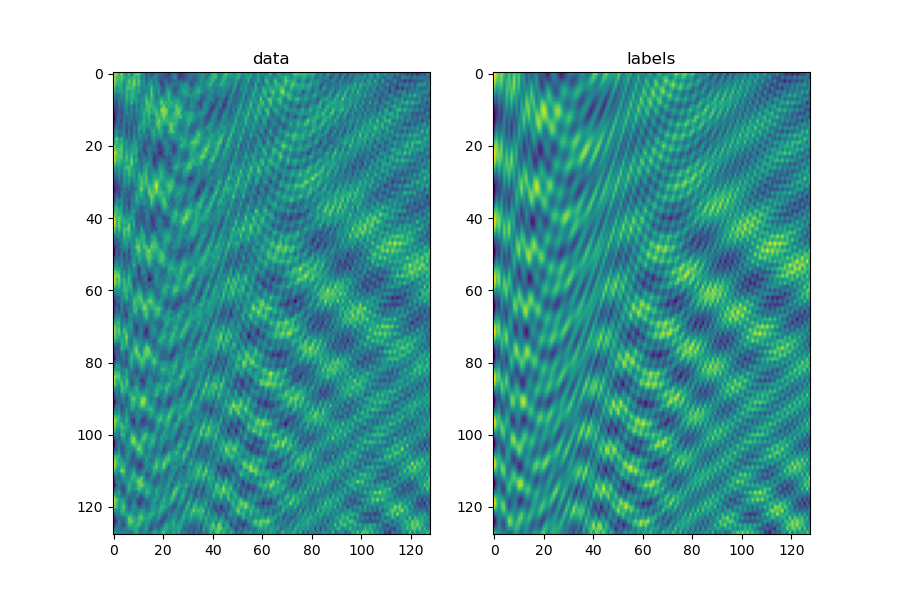

In [5]:
data, labels = next(iter(train_set))   
    
plt.figure(figsize=(9,6))
plt.subplot(1, 2, 1)
plt.imshow(torch.squeeze(data),aspect='auto')
plt.title('data')
plt.subplot(1, 2, 2)
plt.imshow(torch.squeeze(labels),aspect='auto')
plt.title('labels')
plt.show()

In [6]:
cnn_channels=[1,8,16,32,64,32,16,8,1]
kernel_sizes=[3 for _ in range(len(cnn_channels)-1)]

model = CNN(cnn_channels,kernel_sizes)
#model = UNet(cnn_channels,kernel_sizes,bilinear=False,double_conv=True)

model.to(device)

criterion = nn.MSELoss()

#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters())

In [7]:
epochs = 1000
patience = 5
min_loss = float('inf')
model.train()

for t in range(epochs):
    train_loss = train_loop(train_dataloader, model, criterion, optimizer, device)
    test_loss = test_loop(test_dataloader, model, criterion, device)
    
    print('Epoch %i Train error: %0.4f Test error: %0.4f' % (t+1,train_loss,test_loss), end='\r')
    
    if test_loss < min_loss:
        n_not_improved = 0
        print("\nTest error decreased: saving model")
        min_loss = test_loss
        if not os.path.exists('models'):
            os.mkdir('models')
        torch.save(model, 'models/model_checkpoint.pt')
    else:
        n_not_improved += 1
        if n_not_improved>patience:
            print('\nTest error has not decreased for %i iterations. Returning' % n_not_improved)
            break
    
print('\nFinished Training. Final error: %0.4f' % min_loss)

Epoch 1 Train error: 0.0250 Test error: 0.0102
Test error decreased: saving model
Epoch 2 Train error: 0.0090 Test error: 0.0078
Test error decreased: saving model
Epoch 3 Train error: 0.0075 Test error: 0.0067
Test error decreased: saving model
Epoch 4 Train error: 0.0068 Test error: 0.0061
Test error decreased: saving model
Epoch 5 Train error: 0.0062 Test error: 0.0060
Test error decreased: saving model
Epoch 6 Train error: 0.0058 Test error: 0.0055
Test error decreased: saving model
Epoch 8 Train error: 0.0055 Test error: 0.0052
Test error decreased: saving model
Epoch 10 Train error: 0.0048 Test error: 0.0047
Test error decreased: saving model
Epoch 13 Train error: 0.0048 Test error: 0.0046
Test error decreased: saving model
Epoch 15 Train error: 0.0045 Test error: 0.0046
Test error decreased: saving model
Epoch 16 Train error: 0.0043 Test error: 0.0044
Test error decreased: saving model
Epoch 17 Train error: 0.0043 Test error: 0.0042
Test error decreased: saving model
Epoch 18 Tr

In [8]:
# load last checkpoint
model = torch.load('models/model_checkpoint.pt')

In [9]:
test_in, test_labels = next(iter(train_set)) 
test_in = test_in.to(device)
model.eval()
with torch.no_grad():
    test_out = model(test_in[None,:])

<IPython.core.display.Javascript object>


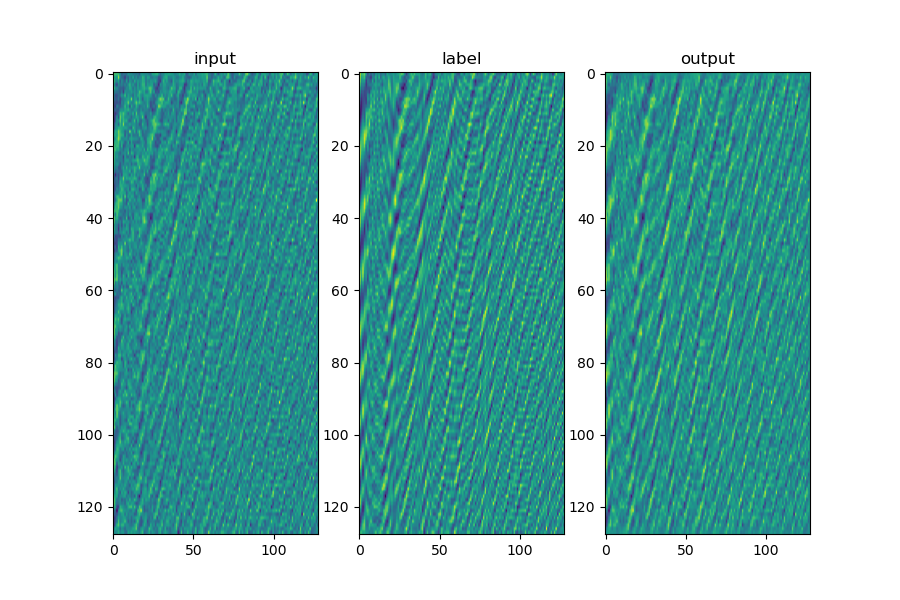

In [10]:
plt.figure(figsize=(9,6))
plt.subplot(1, 3, 1)
plt.imshow(torch.squeeze(test_in).cpu(),aspect='auto')
plt.title('input')
plt.subplot(1, 3, 2)
plt.imshow(torch.squeeze(test_labels).cpu(),aspect='auto')
plt.title('label')
plt.subplot(1, 3, 3)
plt.imshow(torch.squeeze(test_out).cpu(),aspect='auto')
plt.title('output')
plt.show()

<IPython.core.display.Javascript object>


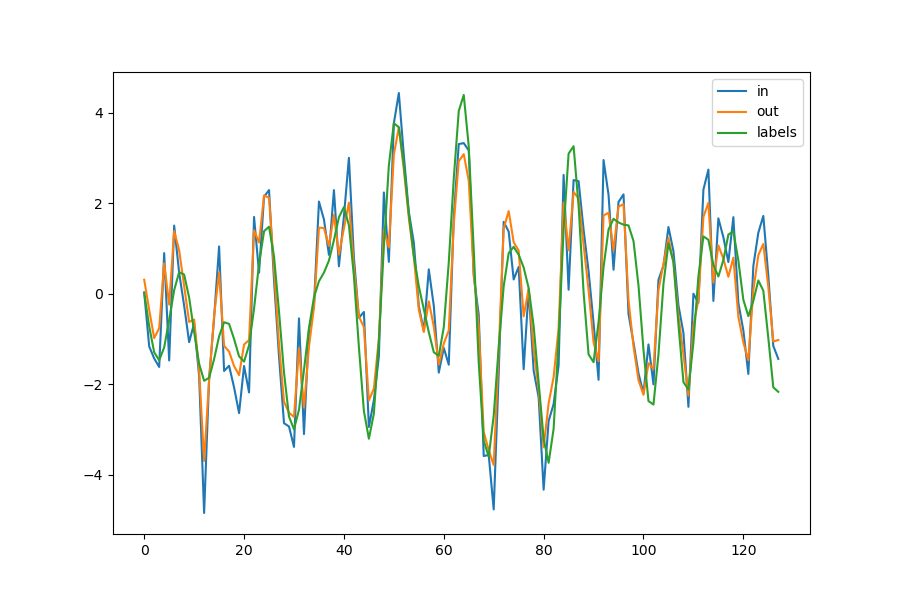

In [11]:
plt.figure(figsize=(9,6))
plt.plot(torch.squeeze(test_in)[:,20].cpu())
plt.plot(torch.squeeze(test_out)[:,20].cpu())
plt.plot(torch.squeeze(test_labels)[:,20].cpu())
plt.legend(['in','out','labels'])
plt.show()